In [4]:
# (No installation required)

In [5]:
# Import required libraries for sentiment analysis with open-source LLMs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import datetime
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
)

print("✓ Setup complete for open-source LLM sentiment analysis")

✓ Setup complete for open-source LLM sentiment analysis


## 1. Load Dataset

Load the FinancialPhraseBank dataset for sentiment analysis.

In [6]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_sentiment
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Few-Shot Examples

Curated examples (2 positive, 2 negative, 1 neutral) representing typical financial sentiment patterns.

In [7]:
# Curated few-shot examples - BALANCED with emphasis on negative detection
FEW_SHOT_EXAMPLES = [
    {
        "sentence": "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.",
        "sentiment": "positive",
        "rationale": "Operating profit increased significantly, indicating improved financial performance.",
    },
    {
        "sentence": "Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.",
        "sentiment": "positive",
        "rationale": "Strong revenue growth of 18.5% signals business expansion and market success.",
    },
    {
        "sentence": "The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.",
        "sentiment": "negative",
        "rationale": "Shift from profit to loss represents deteriorating financial health.",
    },
    {
        "sentence": "Sales decreased by 15% year-over-year due to weakening demand in key markets.",
        "sentiment": "negative",
        "rationale": "Significant sales decline indicates business challenges and market difficulties.",
    },
    {
        "sentence": "Operating loss widened to EUR 5.8 million from EUR 3.2 million in the same period last year.",
        "sentiment": "negative",
        "rationale": "Widening losses show worsening profitability and deteriorating business conditions.",
    },
    {
        "sentence": "The company announced the appointment of a new chief financial officer effective next month.",
        "sentiment": "neutral",
        "rationale": "Executive appointment is routine corporate news without clear financial impact.",
    },
]

print("Few-Shot Examples:")

print("=" * 80)


for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
    print(f"Rationale: {ex['rationale']}")
    print(f"Sentence: {ex['sentence']}")
    print(f"\nExample {i} [{ex['sentiment'].upper()}]:")

Few-Shot Examples:
Rationale: Operating profit increased significantly, indicating improved financial performance.
Sentence: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.

Example 1 [POSITIVE]:
Rationale: Strong revenue growth of 18.5% signals business expansion and market success.
Sentence: Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.

Example 2 [POSITIVE]:
Rationale: Shift from profit to loss represents deteriorating financial health.
Sentence: The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.

Example 3 [NEGATIVE]:
Rationale: Significant sales decline indicates business challenges and market difficulties.
Sentence: Sales decreased by 15% year-over-year due to weakening demand in key markets.

Example 4 [NEGATIVE]:
Rationale: Widening losses show worsening profitability and deteriorating business conditions.
Sentence: Operating loss widened

## 3. Few-Shot Prompt Design

Prompt template for open-source LLMs using few-shot examples.

In [8]:
def create_few_shot_prompt(sentence):
    """
    Creates a few-shot prompt with 6 labeled examples (balanced representation).
    """
    examples_text = ""
    for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
        examples_text += f"""\nExample {i}:
Sentence: "{ex["sentence"]}"
Analysis:
{{
    "sentiment": "{ex["sentiment"]}",
    "confidence": 0.95,
    "rationale": "{ex["rationale"]}"
}}
"""

    prompt = f"""You are a financial sentiment analysis expert. Analyze financial statements with precision.

Classify the sentiment as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Financial improvements, growth, profits, revenue increases, cost reductions, successful expansions
- Negative: Financial declines, losses, revenue drops, cost increases, widening losses, failed ventures, layoffs
- Neutral: Factual statements with no clear financial impact, routine announcements, balanced mixed signals

⚠️ IMPORTANT: Pay special attention to negative indicators (losses, declines, decreases, deterioration).

Here are {len(FEW_SHOT_EXAMPLES)} examples to learn from:
{examples_text}

Now classify this new statement:
Sentence: "{sentence}"

Return ONLY valid JSON in this exact format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation"
}}
"""
    return prompt


# Test prompt
test_sentence = "The company's quarterly revenue exceeded analyst expectations by 12%."
print("=" * 80)
print("FEW-SHOT PROMPT EXAMPLE")

print("=" * 80)
print(create_few_shot_prompt(test_sentence)[:1000] + "...")

FEW-SHOT PROMPT EXAMPLE
You are a financial sentiment analysis expert. Analyze financial statements with precision.

Classify the sentiment as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Financial improvements, growth, profits, revenue increases, cost reductions, successful expansions
- Negative: Financial declines, losses, revenue drops, cost increases, widening losses, failed ventures, layoffs
- Neutral: Factual statements with no clear financial impact, routine announcements, balanced mixed signals

⚠️ IMPORTANT: Pay special attention to negative indicators (losses, declines, decreases, deterioration).

Here are 6 examples to learn from:

Example 1:
Sentence: "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
Analysis:
{
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased significantly, indicating improved financial performance."
}

Example 2:
Sent

## 4. Model Inference Functions

Functions for calling open-source LLMs (Groq API) and parsing their responses.

In [9]:
# Call Ollama models locally via Ollama API for Llama, Qwen, Deepseek
def call_ollama(prompt, model_name, temperature=0.0):
    """
    Call Ollama models locally via Ollama API for Llama, Qwen, Deepseek.
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model_name,
        "prompt": prompt,
        "options": {"temperature": temperature},
        "stream": False
    }
    try:
        import requests
        response = requests.post(url, json=payload)
        response.raise_for_status()
        result = response.json()
        return result.get("response", None)
    except Exception as e:
        print(f"Ollama error: {str(e)[:100]}")
        return None

def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()
        result = json.loads(json_str)
        return result
    except Exception as e:
        print("Parse error: {}".format(str(e)[:100]))
        print("Raw response was:\n{}".format(response_text))
        # Fallback: try to extract sentiment with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None

print("✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)")

✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)


## 5. Run Experiments

Run few-shot sentiment analysis using the same open-source LLMs as in E1, E2, E3 (Zero-Shot):
- **E4:** Llama3.1:8b (Few-Shot)
- **E5:** Qwen3:8b (Few-Shot)
- **E6:** Deepseek-r1:8b (Few-Shot)

All models are called via Ollama API for consistency with the zero-shot experiments.

### E4: ollama/llama3.1:8b (Few-Shot)

Using the same Llama3.1:8b model as in E1, but with few-shot prompt.

In [10]:
# Run on 200 dataset for comprehensive evaluation
test_df = df.head(200).copy()

# E4: llama3.1:8b (Few-Shot)
print("Running E4: llama3.1:8b (Few-Shot)...")
e4_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E4 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="llama3.1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            e4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)  # Rate limiting

e4_df = pd.DataFrame(e4_results)
print(f"\n✓ E4 completed: {len(e4_df)} predictions")
display(e4_df.head())

Running E4: llama3.1:8b (Few-Shot)...


E4 Progress: 100%|██████████| 200/200 [34:00<00:00, 10.20s/it]


✓ E4 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.80,The statement provides information about the c...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Significant revenue growth (doubling of net sa...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Net sales and operating profit both increased ...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,"Operating profit increased significantly, indi..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased from EUR 18.6 mn to...


### E5: ollama/qwen3:8b (Few-Shot)

Using the same Qwen3:8b model as in E2, but with few-shot prompt.

In [11]:
# E5: qwen3:8b (Few-Shot)
print("Running E5: qwen3:8b (Few-Shot)...")
e5_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E5 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="qwen3:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            e5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

e5_df = pd.DataFrame(e5_results)
print(f"\n✓ E5 completed: {len(e5_df)} predictions")
display(e5_df.head())

Running E5: qwen3:8b (Few-Shot)...


E5 Progress: 100%|██████████| 200/200 [2:22:07<00:00, 42.64s/it]  


✓ E5 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.95,Statement focuses on strategic production plan...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,"Net sales doubled, indicating strong growth, a..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Both net sales and operating profit showed sub...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased significantly from ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased from EUR 18.6 mn to...


### E6: ollama/deepseek-r1:8b (Few-Shot)

Using the same Deepseek-r1:8b model as in E3, but with few-shot prompt.

In [12]:
# E6: deepseek-r1:8b (Few-Shot)
print("Running E6: deepseek-r1:8b (Few-Shot)...")
e6_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E6 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="deepseek-r1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            e6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        e6_results.append(
            {
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": "error",
                "confidence": 0,
                "rationale": "Model error",
            }
        )

e6_df = pd.DataFrame(e6_results)
print(f"\n✓ E6 completed: {len(e6_df)} predictions")
display(e6_df.head())

Running E6: deepseek-r1:8b (Few-Shot)...


E6 Progress: 100%|██████████| 200/200 [2:33:27<00:00, 46.04s/it]  


✓ E6 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.90,The statement mentions growth in Russia (posit...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.90,"Net sales doubled, indicating strong revenue g..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Both net sales and operating profit showed sig...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,"Operating profit increased significantly, indi..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased from EUR 18.6 mn to...


## 6. Calculate Metrics

Compute accuracy, F1, precision, recall, and confusion matrices for each model.

In [22]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
e4_metrics, e4_cm, e4_valid = calculate_metrics(e4_df, "E4: Llama-3.1:8b (Few-Shot)")
e5_metrics, e5_cm, e5_valid = calculate_metrics(e5_df, "E5: Qwen3:8b (Few-Shot)")
e6_metrics, e6_cm, e6_valid = calculate_metrics(e6_df, "E6: Deepseek-r1:8b (Few-Shot)")

# Create metrics comparison table
metrics_df = pd.DataFrame([e4_metrics, e5_metrics, e6_metrics])

print("\n" + "=" * 80)
print("FEW-SHOT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


FEW-SHOT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E4: Llama-3.1:8b (Few-Shot),0.98,0.6329,0.6111,0.6598
1,E5: Qwen3:8b (Few-Shot),0.99,0.9141,0.8571,0.9949
2,E6: Deepseek-r1:8b (Few-Shot),0.99,0.9141,0.8571,0.9949


## 7. Visualize Results

Visualize performance metrics and confusion matrices for all open-source LLMs.

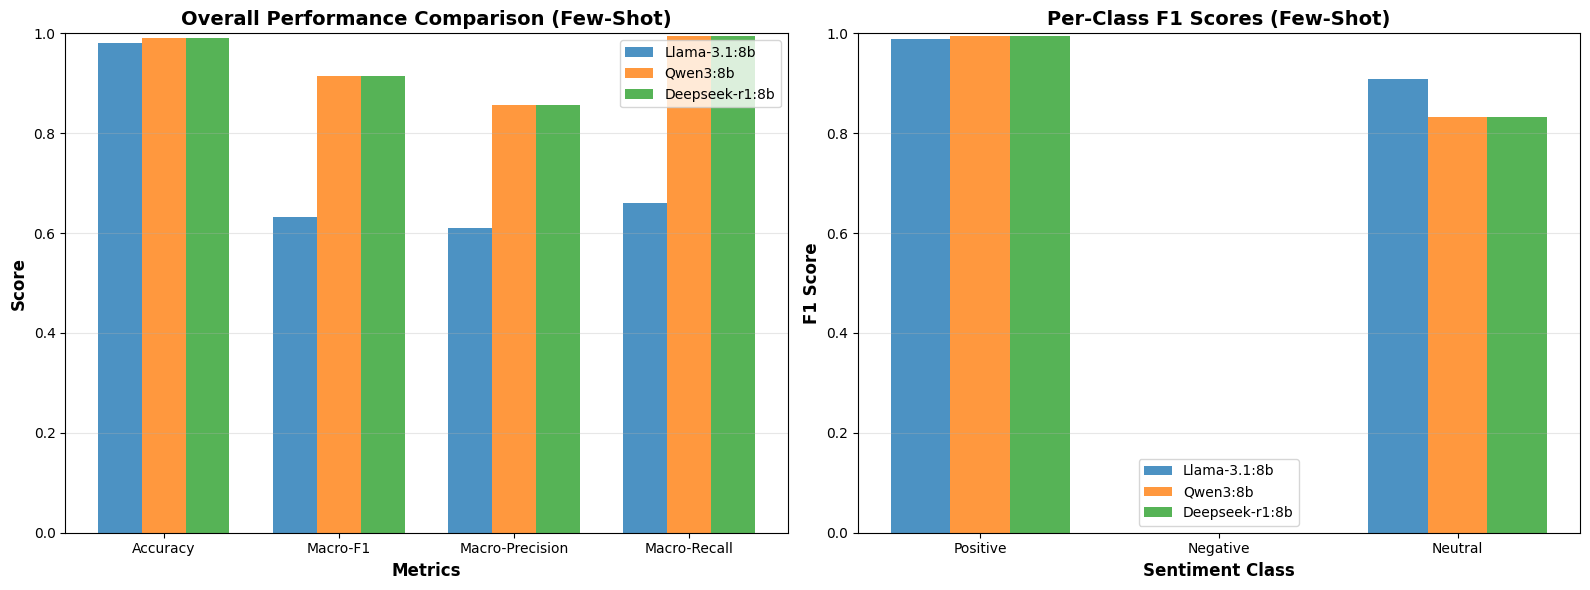

In [23]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (e4_metrics, "Llama-3.1:8b"),
        (e5_metrics, "Qwen3:8b"),
        (e6_metrics, "Deepseek-r1:8b"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Few-Shot)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (e4_metrics, "Llama-3.1:8b"),
        (e5_metrics, "Qwen3:8b"),
        (e6_metrics, "Deepseek-r1:8b"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Few-Shot)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("few_shot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

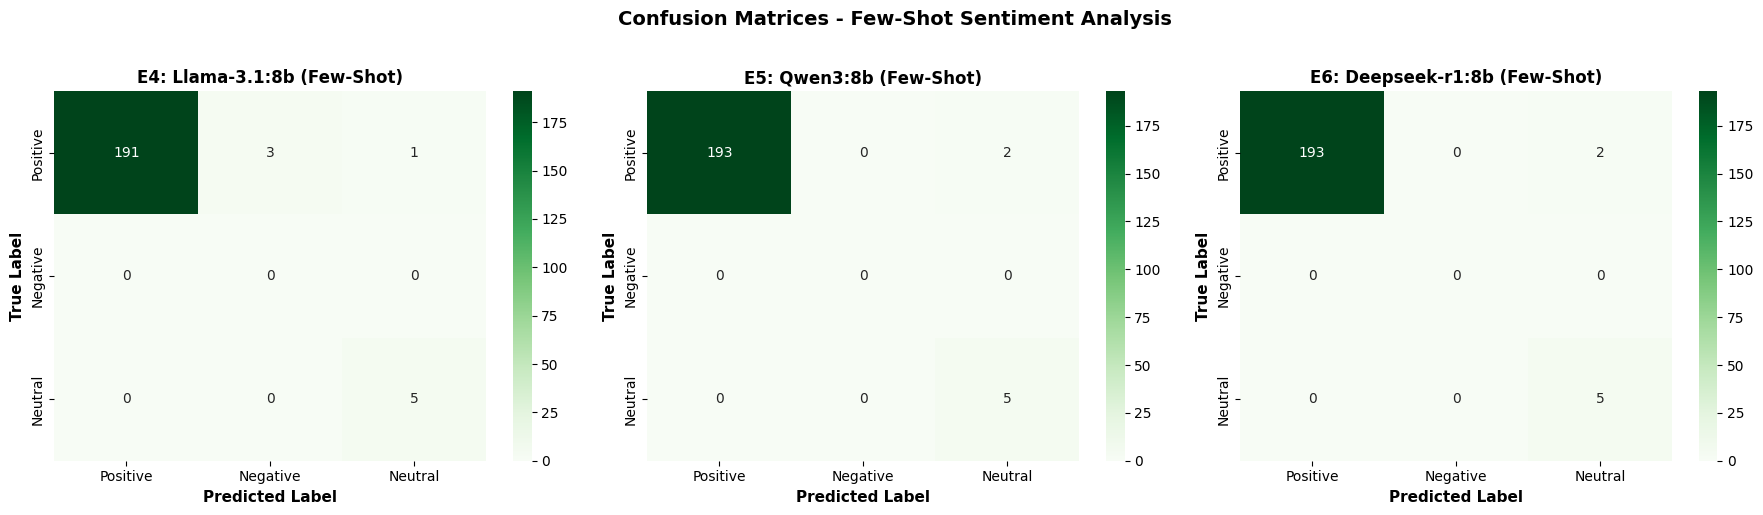

In [24]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e4_cm, "E4: Llama-3.1:8b (Few-Shot)"),
        (e5_cm, "E5: Qwen3:8b (Few-Shot)"),
        (e6_cm, "E6: Deepseek-r1:8b (Few-Shot)"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Few-Shot Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("few_shot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Save Results

Save experiment results and metrics to CSV files.

In [25]:
import datetime
# Save detailed results
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

e4_df.to_csv(f"e4_llama3.1_8b_few_shot_{timestamp}.csv", index=False)
e5_df.to_csv(f"e5_qwen3_8b_few_shot_{timestamp}.csv", index=False)
e6_df.to_csv(f"e6_deepseek_r1_8b_few_shot_{timestamp}.csv", index=False)
metrics_df.to_csv(f"few_shot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")


✓ Results saved with timestamp: 20260214_003637


## 9. Error Analysis

Error analysis for E4, E5, and E6 (llama3.1:8b, qwen3:8b, deepseek-r1:8b) few-shot experiments.

In [26]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: FEW-SHOT MISCLASSIFICATION PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (e4_valid, "E4: Llama-3.1-8B"),
    (e5_valid, "E5: Qwen3-8B"),
    (e6_valid, "E6: Deepseek-r1-8B"),
]:
    print(f"\n{exp_name}")
    print("-" * 80)

    # Identify errors
    errors = df_result[df_result["true_sentiment"] != df_result["predicted_sentiment"]]

    # Count error types
    error_types = (
        errors.groupby(["true_sentiment", "predicted_sentiment"])
        .size()
        .reset_index(name="count")
    )
    error_types = error_types.sort_values("count", ascending=False)

    print(
        f"\nTotal Errors: {len(errors)} / {len(df_result)} ({len(errors) / len(df_result) * 100:.2f}%)"
    )
    print("\nMost Common Error Types:")
    display(error_types.head(5))

    # Show examples of worst errors (high confidence, wrong prediction)
    if len(errors) > 0:
        worst_errors = errors.nlargest(3, "confidence")
        print(f"\nTop 3 High-Confidence Errors:")
        for idx, row in worst_errors.iterrows():
            print(
                f"\n  True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Conf: {row['confidence']:.2f}"
            )
            print(f"  Sentence: {row['sentence'][:120]}...")
            print(f"  Rationale: {row['rationale']}")

# Class-wise Performance Comparison
print("\n" + "=" * 80)
print("CLASS-WISE PERFORMANCE BREAKDOWN")
print("=" * 80)

class_comparison = []
for metrics, model_name in [
    (e4_metrics, "Llama-3.1-8B"),
    (e5_metrics, "Qwen3-8B"),
    (e6_metrics, "Deepseek-r1-8B"),
]:
    for sentiment in ["Positive", "Negative", "Neutral"]:
        class_comparison.append(
            {
                "Model": model_name,
                "Class": sentiment,
                "Precision": metrics[f"{sentiment}_Precision"],
                "Recall": metrics[f"{sentiment}_Recall"],
                "F1-Score": metrics[f"{sentiment}_F1"],
            }
        )

class_df = pd.DataFrame(class_comparison)

# Pivot for better visualization
for metric in ["Precision", "Recall", "F1-Score"]:
    print(f"\n{metric} by Class:")
    pivot = class_df.pivot(index="Class", columns="Model", values=metric)
    display(pivot.round(4))

print("\n" + "=" * 80)
print("COMPREHENSIVE METRICS TABLE")
print("=" * 80)
display(metrics_df.round(4))

ERROR ANALYSIS: FEW-SHOT MISCLASSIFICATION PATTERNS

E4: Llama-3.1-8B
--------------------------------------------------------------------------------

Total Errors: 4 / 200 (2.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count
0,positive,negative,3
1,positive,neutral,1



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.85
  Sentence: The Lithuanian beer market made up 14.41 million liters in January , a rise of 0.8 percent from the year-earlier figure ...
  Rationale: The statement reports market data without any clear financial impact or implications for the company's performance.

  True: positive | Predicted: negative | Conf: 0.80
  Sentence: Sales have risen in other export markets ....
  Rationale: The statement mentions 'other export markets', implying that sales have not risen in the primary or most significant market, which could be a concern.

  True: positive | Predicted: negative | Conf: 0.80
  Sentence: Operating profit rose to EUR 4.7 mn from EUR 4.6 mn ....
  Rationale: Operating profit increased by a minimal amount, indicating no significant financial improvement.

E5: Qwen3-8B
--------------------------------------------------------------------------------

Total Errors: 2 / 200 (1.00%)

Most Common Error 

,true_sentiment,predicted_sentiment,count
0,positive,neutral,2



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.95
  Sentence: The agreement strengthens our long-term partnership with Nokia Siemens Networks ....
  Rationale: The statement describes a strategic partnership development but lacks direct financial metrics or clear impact on profitability/revenue, remaining factual and non-committal.

  True: positive | Predicted: neutral | Conf: 0.95
  Sentence: Shares of Standard Chartered ( STAN ) rose 1.2 % in the FTSE 100 , while Royal Bank of Scotland ( RBS ) shares rose 2 % ...
  Rationale: Stock price increases are factual market movements without direct indication of underlying financial performance or specific financial metrics.

E6: Deepseek-r1-8B
--------------------------------------------------------------------------------

Total Errors: 2 / 200 (1.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count
0,positive,neutral,2



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.95
  Sentence: Shares of Standard Chartered ( STAN ) rose 1.2 % in the FTSE 100 , while Royal Bank of Scotland ( RBS ) shares rose 2 % ...
  Rationale: The statement reports stock price increases but lacks context or direct financial data, making it a factual observation without clear financial impact.

  True: positive | Predicted: neutral | Conf: 0.95
  Sentence: Net sales grew in the period to  x20ac 402 million $ 585US million from  x20ac 401 million in 2006 ....
  Rationale: Net sales increased slightly from 401 million to 402 million, but the minimal growth does not indicate significant financial improvement.

CLASS-WISE PERFORMANCE BREAKDOWN

Precision by Class:


Model,Deepseek-r1-8B,Llama-3.1-8B,Qwen3-8B
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,0.7143,0.8333,0.7143
Positive,1.0000,1.0000,1.0000



Recall by Class:


Model,Deepseek-r1-8B,Llama-3.1-8B,Qwen3-8B
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,1.0000,1.0000,1.0000
Positive,0.9897,0.9795,0.9897



F1-Score by Class:


Model,Deepseek-r1-8B,Llama-3.1-8B,Qwen3-8B
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,0.8333,0.9091,0.8333
Positive,0.9948,0.9896,0.9948



COMPREHENSIVE METRICS TABLE


,Experiment,Total Samples,Valid Predictions,Accuracy,Macro-F1,Weighted-F1,Macro-Precision,Macro-Recall,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,E4: Llama-3.1:8b (Few-Shot),200,200,0.98,0.6329,0.9876,0.6111,0.6598,1.0,0.9795,0.9896,0.0,0.0,0.0,0.8333,1.0,0.9091
1,E5: Qwen3:8b (Few-Shot),200,200,0.99,0.9141,0.9908,0.8571,0.9949,1.0,0.9897,0.9948,0.0,0.0,0.0,0.7143,1.0,0.8333
2,E6: Deepseek-r1:8b (Few-Shot),200,200,0.99,0.9141,0.9908,0.8571,0.9949,1.0,0.9897,0.9948,0.0,0.0,0.0,0.7143,1.0,0.8333


## 10. Confidence Analysis

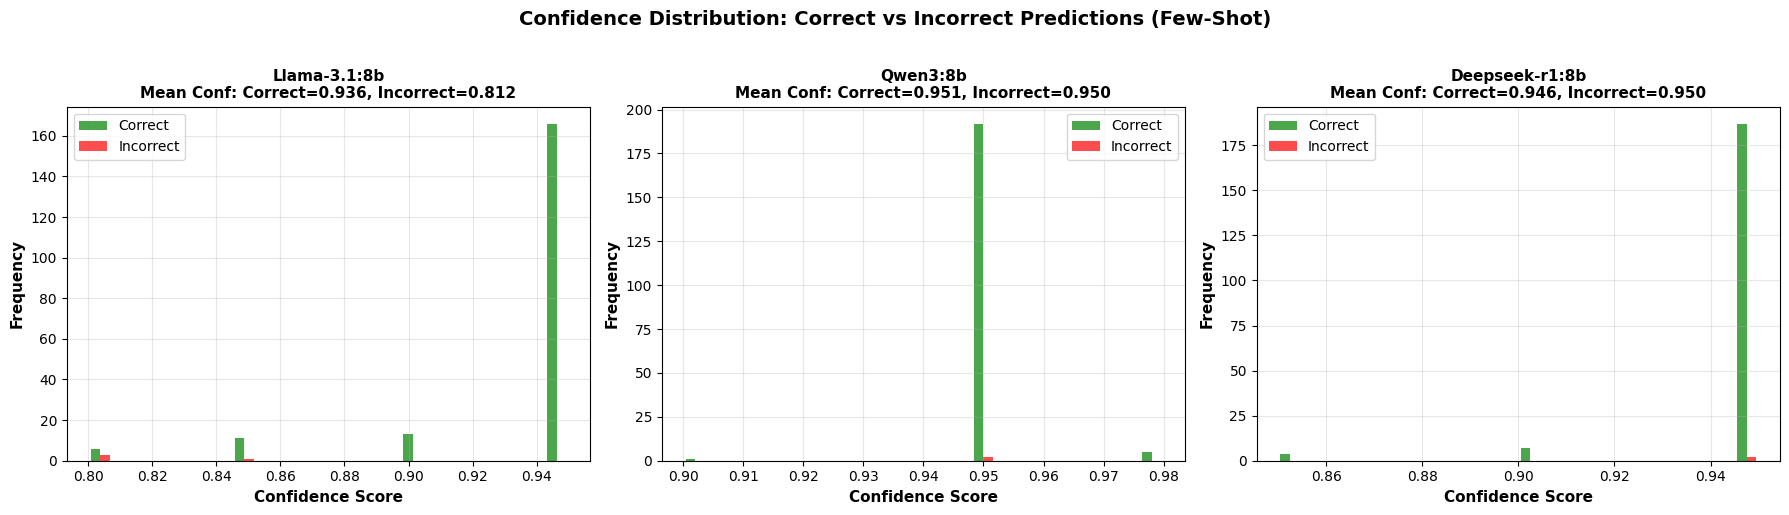


CONFIDENCE CALIBRATION ANALYSIS

E4: Llama3.1:8B:
  Average Confidence (Correct): 0.9365
  Average Confidence (Incorrect): 0.8125
  Calibration Gap: 0.1240
  Total Correct: 196 / 200

  Confidence by Predicted Class:
    Positive: 0.9369 (n=191)
    Negative: 0.8000 (n=3)
    Neutral: 0.9083 (n=6)

E5: Qwen3:8b:
  Average Confidence (Correct): 0.9505
  Average Confidence (Incorrect): 0.9500
  Calibration Gap: 0.0005
  Total Correct: 198 / 200

  Confidence by Predicted Class:
    Positive: 0.9505 (n=193)
    Neutral: 0.9500 (n=7)

E6: Deepseek-r1:8b:
  Average Confidence (Correct): 0.9462
  Average Confidence (Incorrect): 0.9500
  Calibration Gap: -0.0038
  Total Correct: 198 / 200

  Confidence by Predicted Class:
    Positive: 0.9464 (n=193)
    Neutral: 0.9429 (n=7)


In [27]:
# Confidence Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(e4_valid, "Llama-3.1:8b"), (e5_valid, "Qwen3:8b"), (e6_valid, "Deepseek-r1:8b")]
):
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions (Few-Shot)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("few_shot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("CONFIDENCE CALIBRATION ANALYSIS")
print("=" * 80)
for df_result, exp_name in [
    (e4_valid, "E4: Llama3.1:8B"),
    (e5_valid, "E5: Qwen3:8b"),
    (e6_valid, "E6: Deepseek-r1:8b"),
]:
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    avg_conf_correct = df_result[df_result["correct"]]["confidence"].mean()
    avg_conf_incorrect = df_result[~df_result["correct"]]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"\n{exp_name}:")
    print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
    print(f"  Average Confidence (Incorrect): {avg_conf_incorrect:.4f}")
    print(f"  Calibration Gap: {calibration_gap:.4f}")
    print(f"  Total Correct: {df_result['correct'].sum()} / {len(df_result)}")

    # Confidence by sentiment class
    print(f"\n  Confidence by Predicted Class:")
    for sentiment in ["positive", "negative", "neutral"]:
        class_df = df_result[df_result["predicted_sentiment"] == sentiment]
        if len(class_df) > 0:
            print(
                f"    {sentiment.capitalize()}: {class_df['confidence'].mean():.4f} (n={len(class_df)})"
            )

## 11. Classification Reports

In [28]:
# Detailed Classification Reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for df_result, exp_name in [
    (e4_valid, "E4: Llama-3.1-8B"),
    (e5_valid, "E5: Qwen3-8B"),
    (e6_valid, "E6: Deepseek-r1-8B"),
]:
    print("\n" + "=" * 80)
    print(f"{exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_sentiment"],
            df_result["predicted_sentiment"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )

# Class-wise Metrics Summary Table
print("\n" + "=" * 80)
print("CLASS-WISE METRICS SUMMARY")
print("=" * 80)

summary_data = []
for metrics, model in [
    (e4_metrics, "Llama-3.1:8b"),
    (e5_metrics, "Qwen3..1:8b"),
    (e6_metrics, "deepseek-r1:8b"),
]:
    summary_data.append(
        {
            "Model": model,
            "Pos_P": metrics["Positive_Precision"],
            "Pos_R": metrics["Positive_Recall"],
            "Pos_F1": metrics["Positive_F1"],
            "Neg_P": metrics["Negative_Precision"],
            "Neg_R": metrics["Negative_Recall"],
            "Neg_F1": metrics["Negative_F1"],
            "Neu_P": metrics["Neutral_Precision"],
            "Neu_R": metrics["Neutral_Recall"],
            "Neu_F1": metrics["Neutral_F1"],
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\nPer-Class Metrics (P=Precision, R=Recall, F1=F1-Score):")
display(summary_df.round(4))


DETAILED CLASSIFICATION REPORTS

E4: Llama-3.1-8B
              precision    recall  f1-score   support

    Positive       1.00      0.98      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       0.83      1.00      0.91         5

    accuracy                           0.98       200
   macro avg       0.61      0.66      0.63       200
weighted avg       1.00      0.98      0.99       200


E5: Qwen3-8B
              precision    recall  f1-score   support

    Positive       1.00      0.99      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       0.71      1.00      0.83         5

    accuracy                           0.99       200
   macro avg       0.57      0.66      0.61       200
weighted avg       0.99      0.99      0.99       200


E6: Deepseek-r1-8B
              precision    recall  f1-score   support

    Positive       1.00      0.99      0.99       195
    Negative       0.00      0.00      0.00 

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to

,Model,Pos_P,Pos_R,Pos_F1,Neg_P,Neg_R,Neg_F1,Neu_P,Neu_R,Neu_F1
0,Llama-3.1:8b,1.0,0.9795,0.9896,0.0,0.0,0.0,0.8333,1.0,0.9091
1,Qwen3..1:8b,1.0,0.9897,0.9948,0.0,0.0,0.0,0.7143,1.0,0.8333
2,deepseek-r1:8b,1.0,0.9897,0.9948,0.0,0.0,0.0,0.7143,1.0,0.8333


## 12. Few-Shot vs Zero-Shot Comparison

In [29]:
# Compare with Zero-Shot results (if available)
import glob
import os

print("=" * 80)
print("FEW-SHOT vs ZERO-SHOT COMPARISON")
print("=" * 80)

# Try to load the latest zero-shot results
zero_shot_files = glob.glob("../Zero_Shot/zero_shot_metrics_summary_*.csv")

if zero_shot_files:
    # Get the most recent file
    latest_zero_shot = max(zero_shot_files, key=os.path.getctime)
    print(f"\nLoading Zero-Shot results from: {os.path.basename(latest_zero_shot)}")

    try:
        zero_shot_df = pd.read_csv(latest_zero_shot)

        # Combine Few-Shot and Zero-Shot for comparison
        few_shot_df = metrics_df.copy()
        few_shot_df["Approach"] = "Few-Shot"
        zero_shot_df["Approach"] = "Zero-Shot"

        # Select key metrics for comparison
        comparison_cols = [
            "Experiment",
            "Approach",
            "Accuracy",
            "Macro-F1",
            "Negative_F1",
            "Positive_F1",
            "Neutral_F1",
        ]

        combined = pd.concat(
            [
                few_shot_df[comparison_cols]
                if all(col in few_shot_df.columns for col in comparison_cols)
                else few_shot_df,
                zero_shot_df[comparison_cols]
                if all(col in zero_shot_df.columns for col in comparison_cols)
                else zero_shot_df,
            ]
        )

        print("\nKey Metrics Comparison:")
        display(combined[comparison_cols].round(4))

        # Calculate improvements
        print("\n" + "=" * 80)
        print("IMPROVEMENT: Few-Shot vs Zero-Shot")
        print("=" * 80)

        model_names = ["Llama3.1:8b", "Qwen3:8b", "Deepseek-r1:8b"]
        for i in range(min(3, len(few_shot_df))):
            model_name = model_names[i]
            if i < len(zero_shot_df):
                fs_macro = few_shot_df.iloc[i]["Macro-F1"]
                zs_macro = zero_shot_df.iloc[i]["Macro-F1"]
                improvement = (
                    ((fs_macro - zs_macro) / zs_macro * 100) if zs_macro > 0 else 0
                )

                fs_neg = few_shot_df.iloc[i]["Negative_F1"]
                zs_neg = zero_shot_df.iloc[i]["Negative_F1"]
                neg_improvement = (
                    ((fs_neg - zs_neg) / zs_neg * 100)
                    if zs_neg > 0
                    else float("inf")
                    if fs_neg > 0
                    else 0
                )

                print(f"\n{model_name}:")
                print(
                    f"  Macro-F1: {zs_macro:.4f} → {fs_macro:.4f} ({improvement:+.2f}%)"
                )
                print(
                    f"  Negative F1: {zs_neg:.4f} → {fs_neg:.4f} ({neg_improvement:+.2f}% improvement)"
                    if neg_improvement != float("inf")
                    else f"  Negative F1: {zs_neg:.4f} → {fs_neg:.4f} (∞% - from zero!)"
                )

    except Exception as e:
        print(f"\n⚠️ Could not load zero-shot results: {str(e)}")
        print("Run Zero-Shot experiments first for comparison.")
else:
    print("\n⚠️ No Zero-Shot results found in ../Zero_Shot/")
    print("Run Zero-Shot experiments first to enable comparison.")

FEW-SHOT vs ZERO-SHOT COMPARISON

Loading Zero-Shot results from: zero_shot_metrics_summary_20260211_053519.csv

Key Metrics Comparison:


,Experiment,Approach,Accuracy,Macro-F1,Negative_F1,Positive_F1,Neutral_F1
0,E4: Llama-3.1:8b (Few-Shot),Few-Shot,0.980,0.6329,0.0,0.9896,0.9091
1,E5: Qwen3:8b (Few-Shot),Few-Shot,0.990,0.9141,0.0,0.9948,0.8333
2,E6: Deepseek-r1:8b (Few-Shot),Few-Shot,0.990,0.9141,0.0,0.9948,0.8333
0,E1: llama3.1:8b,Zero-Shot,1.000,1.0000,0.0,1.0000,1.0000
1,E2: qwen3:8b,Zero-Shot,1.000,1.0000,0.0,1.0000,1.0000
2,E3: deepseek-r1:8b,Zero-Shot,0.995,0.9533,0.0,0.9974,0.9091



IMPROVEMENT: Few-Shot vs Zero-Shot

Llama3.1:8b:
  Macro-F1: 1.0000 → 0.6329 (-36.71%)
  Negative F1: 0.0000 → 0.0000 (+0.00% improvement)

Qwen3:8b:
  Macro-F1: 1.0000 → 0.9141 (-8.59%)
  Negative F1: 0.0000 → 0.0000 (+0.00% improvement)

Deepseek-r1:8b:
  Macro-F1: 0.9533 → 0.9141 (-4.11%)
  Negative F1: 0.0000 → 0.0000 (+0.00% improvement)
